In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import seaborn as sn

from tqdm import notebook

In [2]:
def set_seed_everywhere(seed, cuda = True):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [3]:
SEED = 1668
set_seed_everywhere(SEED)

### Download

Download train and test dataset, but it will be mixed and a 3rd group, `validation` will be created

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

Files already downloaded and verified


In [6]:
X = [entry[0] for entry in trainset] + [entry[0] for entry in testset]
y = [entry[1] for entry in trainset] + [entry[1] for entry in testset]

### Create Train, Test, and Validation datasets

In [7]:
test_ratio = 0.15
valid_ratio = 0.15

valid_ratio = valid_ratio / (1.0 - test_ratio)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio, random_state = SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = valid_ratio, random_state = SEED)

In [9]:
print(f"Train dataset size: {len(X_train)}")
print(f"Test dataset size: {len(X_test)}")
print(f"Validation dataset size: {len(X_val)}")

Train dataset size: 42000
Test dataset size: 9000
Validation dataset size: 9000


In [10]:
trainset = [(X_train[idx], y_train[idx]) for idx in range(len(X_train))]
validset = [(X_val[idx], y_val[idx]) for idx in range(len(X_val))]
testset = [(X_test[idx], y_test[idx]) for idx in range(len(X_test))]

In [11]:
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [12]:
def show_image(image):
    np_img = image.numpy()
    plt.xlabel = "Bra"
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


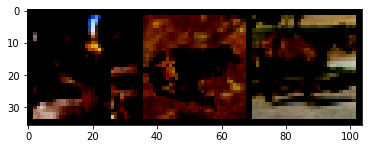

[5, 6, 7]


In [13]:
images = [X_train[0], X_test[0], X_val[0]]
labels = [y_train[0], y_test[0], y_val[0]]

show_image(torchvision.utils.make_grid(images))
print(labels)

In [14]:
class CNN(nn.Module):
    def __init__(self, conv, fc, pool):
        super().__init__()
        self.conv = nn.ModuleList([c for c in conv])
        self.fc = nn.ModuleList([f for f in fc])
        self.pool = pool

    def forward(self, x):
        for conv in self.conv:
            x = self.pool(F.relu(conv(x)))

        x = torch.flatten(x, 1)
        
        for idx in range(len(self.fc) - 1):
           x = F.relu(self.fc[idx](x))
        
        x = self.fc[len(self.fc) - 1](x)
        
        return x

In [15]:
def train(model, iterator, optimizer, criterion, bar):

    epoch_loss = 0
    
    model.train()
    
    for idx, data in enumerate(iterator):
        
        inputs, labels = data

        optimizer.zero_grad()

        inputs = inputs.cuda() if use_cuda else inputs
        labels = labels.cuda() if use_cuda else labels
                
        predictions = model(inputs)

        loss = criterion(predictions, labels)       
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        bar.set_postfix(loss=epoch_loss / (idx + 1))
        bar.update()

    return epoch_loss / len(iterator)

In [16]:
def evaluate(model, iterator, criterion, bar):
    
    epoch_loss = 0
    
    model.eval()
    total_predicted = []
    
    with torch.no_grad():
    
        for idx, batch in enumerate(iterator):
            inputs, labels = batch

            inputs = inputs.cuda() if use_cuda else inputs
            labels = labels.cuda() if use_cuda else labels
            
            predictions = model(inputs)
           
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()

            _, predicted = torch.max(predictions.data, 1)
            total_predicted += predicted.tolist()
            
            bar.set_postfix(loss=epoch_loss / (idx + 1))
            bar.update()

    return epoch_loss / len(iterator), total_predicted

In [21]:
epochs = 10

`[(W−K+2P)/S]+1`

- W is the input volume  
- K is the Kernel size
- P is the padding
- S is the stride   

In [22]:
setups = [
    # 32 - 3 + 0 / 1 + 1 = 30 / 2 = 15
    # 15 - 3 + 0 / 1 + 1 = 13 / 2 = 6
    # 16 * 6 * 6
    (   
        [nn.Conv2d(3, 6, 3), nn.Conv2d(6, 16, 3)],
        [nn.Linear(16 * 6 * 6, 120), nn.Linear(120, 84), nn.Linear(84, 10)],
        nn.MaxPool2d(2, 2)
    ),
    # 32 - 5 + 0 / 1 + 1 = 28 / 2 = 14
    # 14 - 5 + 0 / 1 + 1 = 10 / 2 = 5
    # 16 * 5 * 5
    (
        [nn.Conv2d(3, 6, 5), nn.Conv2d(6, 16, 5)],
        [nn.Linear(16 * 5 * 5, 120), nn.Linear(120, 84), nn.Linear(84, 10)],
        nn.MaxPool2d(2, 2)
    ),
    # 32 - 3 + 0 / 1 + 1 = 30 / 2 = 15
    # 15 - 3 + 0 / 1 + 1 = 13 / 2 = 6
    # 8 * 6 * 6
    (
        [nn.Conv2d(3, 4, 3), nn.Conv2d(4, 8, 3)],
        [nn.Linear(8 * 6 * 6, 120), nn.Linear(120, 84), nn.Linear(84, 10)],
        nn.AvgPool2d(2, 2)
    ),
    (
    # 32 - 3 + 0 / 1 + 1 = 30 / 2 = 15
    # 15 - 3 + 0 / 1 + 1 = 13 / 2 = 6
    # 6 - 3 + 0 / 1 + 1 = 4 / 2 = 2
    # 128 * 2 * 2
        [nn.Conv2d(3, 32, 3), nn.Conv2d(32, 64, 3), nn.Conv2d(64, 128, 3)],
        [nn.Linear(128 * 2 * 2, 128), nn.Linear(128, 64), nn.Linear(64, 32), nn.Linear(32, 10)],
        nn.MaxPool2d(2, 2)
    )
]

training routine:   0%|          | 0/10 [00:00<?, ?it/s]

train:   0%|          | 0/10500 [00:00<?, ?it/s]

valid:   0%|          | 0/2250 [00:00<?, ?it/s]

test:   0%|          | 0/2250 [00:00<?, ?it/s]

0.6256666666666667
0.5964444444444444
0.5784444444444444
0.6881111111111111


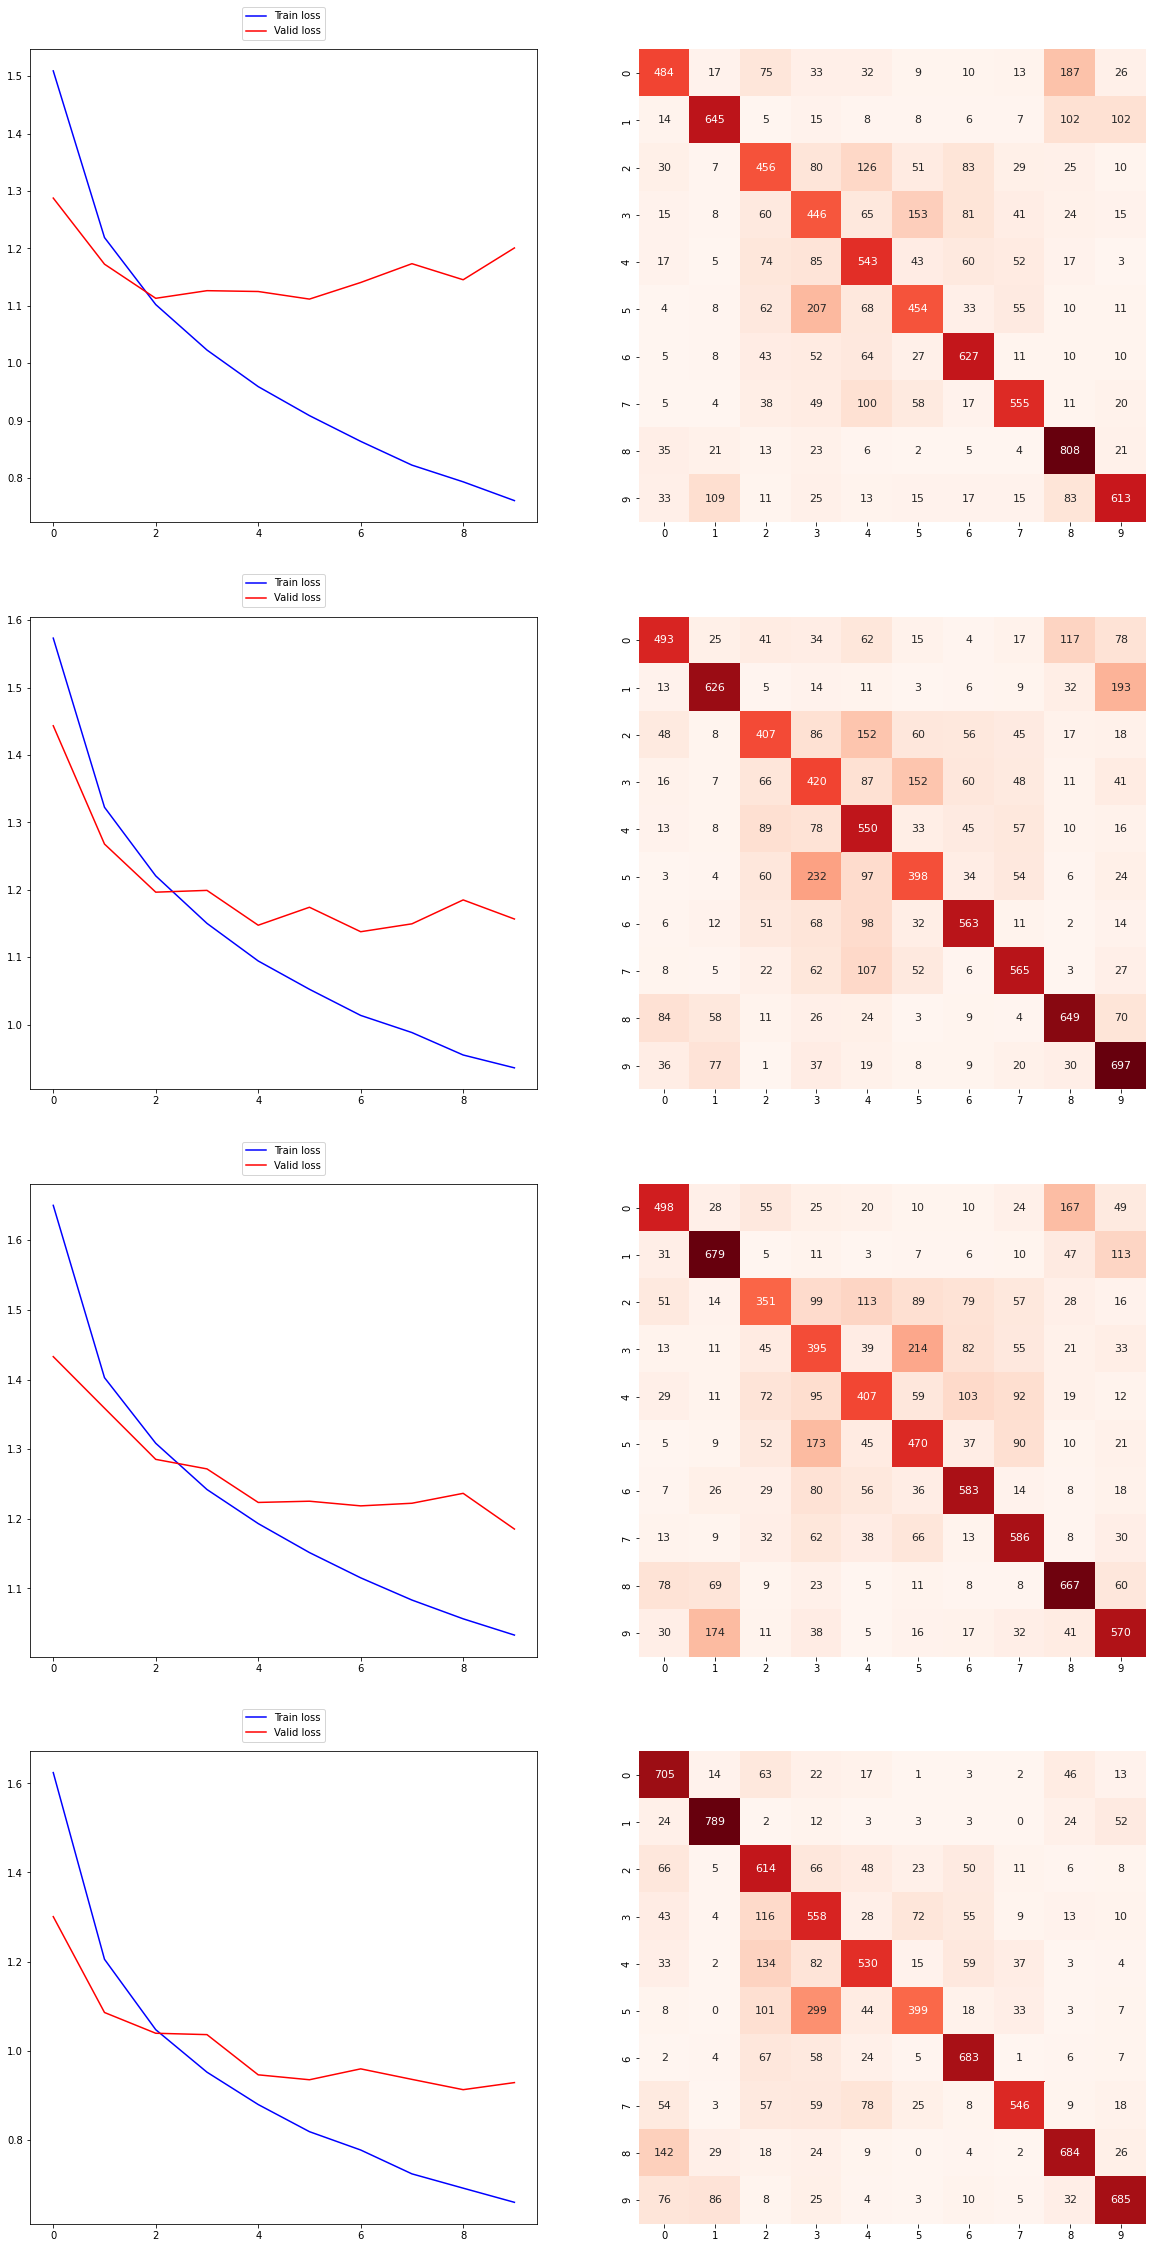

In [23]:
fig, axs = plt.subplots(len(setups), 2, figsize=(10 * 2, 10 * len(setups)))

epoch_bar = notebook.tqdm(desc='training routine', total=epochs, position=0)
train_bar = notebook.tqdm(desc='train', total=len(trainloader),position=0,leave=True)
val_bar = notebook.tqdm(desc='valid',total=len(validloader), position=0, leave=True)
test_bar = notebook.tqdm(desc='test', total=len(testloader), position=0, leave=True)

for setup_idx, setup in enumerate(setups):

    epoch_bar.n = 0
    train_bar.n = 0
    val_bar.n = 0
    test_bar.n = 0
    
    epoch_bar.refresh()
    train_bar.refresh()
    val_bar.refresh()
    test_bar.refresh()

    conv, fc, pool = setup
    cnn = CNN(conv, fc, pool)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    cnn = cnn.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)

    # Training

    best_valid_loss = float('inf')

    train_loss = []
    valid_loss = []

    for epoch in range(epochs):

        t_loss = train(cnn, trainloader, optimizer, criterion, train_bar)
        v_loss, _ = evaluate(cnn, validloader, criterion, val_bar)

        if v_loss < best_valid_loss:
            best_valid_loss = v_loss
            torch.save(cnn.state_dict(), 'CNN.pt')

        train_loss.append(t_loss)
        valid_loss.append(v_loss)

        train_bar.n = 0
        val_bar.n = 0 
        train_bar.refresh()
        val_bar.refresh()
        epoch_bar.update()

    axs[setup_idx, 0].plot([*range(epochs)], train_loss, color = 'b', label='Train loss')
    axs[setup_idx, 0].plot([*range(epochs)], valid_loss, color = 'r', label='Valid loss')
    axs[setup_idx, 0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=1)
    
    # Testing
    cnn.load_state_dict(torch.load('CNN.pt'))
    _, total_predicted = evaluate(cnn, testloader, criterion, test_bar)

    test_target = []

    for batch in testloader:
        inputs, labels = batch
        test_target += labels

    cm = confusion_matrix(test_target, total_predicted)
    heatmap = sn.heatmap(cm, annot=True, cmap='Reds', ax=axs[setup_idx, 1], fmt='g', annot_kws={"size": 11}, cbar=False)

    print(accuracy_score(test_target, total_predicted))

plt.show()